<font color="#483D8B">
<h1  align="center">Examining Multiple Classification Models while Tuning Hyperparameters</h1>
<h3 align="center"> Ansh Sikka</h3>
<h3 align="center"> 02/25/2019</h3>

## Overview
### Goals
* Create multiple classification models
    * Bagging
    * Boosting
    * Random Forest
* Interpret models from performance measures
* Undersampling, oversampling, and SMOTE techniques for unbalanced classes

### Skills
* Be able to create a classification model
* Understand undersampling, oversampling, and SMOTE

## Data 
The dataset used was a Caravan Insurance dataset from Kaggle. The link to the dataset is https://www.kaggle.com/uciml/caravan-insurance-challenge/version/1.

Let's start by importing libraries needed to work with the data.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingClassifier
from sklearn import model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score

In [25]:
# import csv data into pandas dataframe

insurance_df = pd.read_csv('caravan-insurance-challenge.csv')

In [26]:
# train/test split
insurance_array = insurance_df.values 
y = insurance_array[:, -1]
y=y.astype('int')
x = insurance_array[:, 1:-1]

X_train = x[0: 5822]
Y_train = y[0: 5822]

x_test = x[5822:9822]
y_test = y[5822:9822]

## Exploratory Data Analysis and Models

### Classification Using Bagging
Bagging is used to improve the stability and accuracy of machine learning algorithms. It helps  fix overfitting and variance. 
#### Unbalanced Data
We need to unbalance the data by training the system with more people who didn't buy the caravan.
Since our distribution of people who didn't buy the caravan vs people who did is higher, it is already unbalanced. 

In [27]:
def score_model(model, xtest, ytest):
    score = 0
    results = []
    for i in range(len(xtest)):
        result = model.predict([xtest[i]])
        results.append(result)
        if result == ytest[i]:
            score+=1
        else:
            continue
    return score/len(xtest), results

In [28]:

def plot_model(ytest, yresults):
    min_actual_y = min(yresults)
    min_pred_y = min(ytest)

    max_actual_y = max(yresults)
    max_pred_y = max(ytest)

    min_y = min(min_actual_y, min_pred_y)
    max_y = max(max_actual_y, max_pred_y)
    %matplotlib inline
    fig, ax = plt.subplots()
    ax.scatter(ytest, yresults, edgecolors=(0, 0, 0))
    ax.plot([min_y, max_y], [min_y, max_y], 'k--', lw = 4)
    ax.set_xlabel("Measured")
    ax.set_ylabel("Predicted")
    plt.show()
    

Bagging Accuracy with Unbalanced and Oversampled Data:  0.93025
AUC Score:  0.5280056201108833


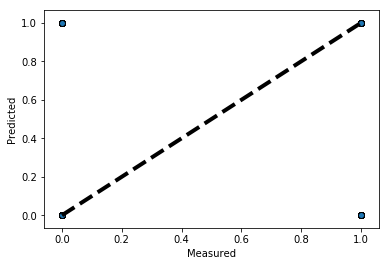

In [9]:
tree = DecisionTreeClassifier().fit(X_train, Y_train)
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)
bag.fit(X_train, Y_train)
bagging_score = score_model(bag, x_test, y_test)
print("Bagging Accuracy with Unbalanced Data: ", bagging_score[0])
print("AUC Score: ", roc_auc_score(y_test, bagging_score[1]))
plot_model(y_test, bagging_score[1])

##### Interpretation
As we can see, the accuracy is 0.93, which means the tests significantly perform well based on the trained data. However this unbalanced data may have overfitted our model. The test cases might have matched the training cases well. 

#### Oversampled Data
Oversampling is when we increase the frequency of data points corresponding to the minority class. We will use a sci-kit learn method to oversample the data. 



Bagging Accuracy with Oversampled Data (Balanced):  0.5457203615098352
AUC Score:  0.5457203615098352


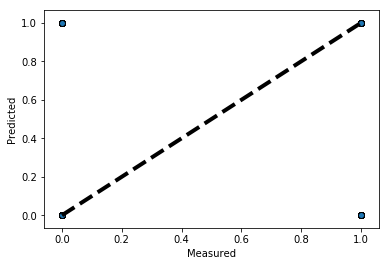

In [16]:
ros = RandomOverSampler(random_state=0)
X_train_oversampled, Y_train_oversampled = ros.fit_resample(X_train, Y_train)
x_test_oversampled, y_test_oversampled = ros.fit_resample(x_test, y_test)
tree_oversample = DecisionTreeClassifier().fit(X_train_oversampled, Y_train_oversampled)
bag_oversample = BaggingClassifier(tree_oversample, n_estimators=100, max_samples=0.8, random_state=1)
bag_oversample.fit(X_train_oversampled, Y_train_oversampled)
bag_oversample_score = score_model(bag_oversample, x_test_oversampled, y_test_oversampled)
print("Bagging Accuracy with Oversampled Data (Balanced): ", bag_oversample_score[0])
print("AUC Score: ", roc_auc_score(y_test_oversampled, bag_oversample_score[1]))
plot_model(y_test_oversampled, bag_oversample_score[1])


##### Interpretation
We can see that this yielded an accuracy way lower than before. This is probably due to more overfitting since we have enough data points considering both classes. However, the overfitting was caused by extreme match to the original dataset. 

#### Undersampled Data
Since we have a lot more people that don't buy Caravan insurance, we need to undersample the data to get a higher training set. Let's split the data in a way where there are equal samples with people who bought Caravan insurance and those who didn't, a 50/50 split. This will help balance the data. 

In [29]:
all_ones = insurance_array[np.where(insurance_array[:, -1] == 1)]
all_zeroes = insurance_array[np.where(insurance_array[:,-1] == 0)]
print("Size of array with people who bought insurance: ", len(all_ones))
print("Size of array with people who did not buy insurance: ", len(all_zeroes))



Size of array with people who bought insurance:  586
Size of array with people who did not buy insurance:  9236


As we can see, the data is totally unbalanced! Let's fix it by undersampling the the people who did not buy insurance and rebalance the data. We can do this with a 50/50 split. Let's use 293 samples from each class (bought vs not. bought) to train an 293 samples to test. 

In [30]:
y_undersample = np.concatenate((all_ones[0:293, -1], all_zeroes[0:293, -1]))
y_undersample = y_undersample.astype('int')
x_undersample = np.concatenate((all_ones[0:293, 1:-1], all_zeroes[0:293, 1: -1]))
X_undersample_train, x_undersample_test, Y_undersample_train, y_undersample_test = train_test_split(x_undersample, y_undersample, test_size = 0.3)

Bagging Accuracy with Undersampled Data (Balanced):  0.6704545454545454
AUC Score:  0.6745692447208187


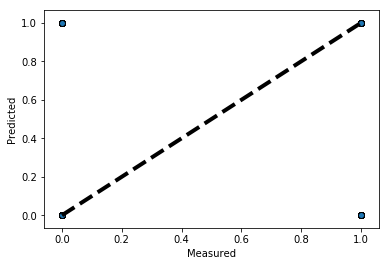

In [31]:
tree_undersample = DecisionTreeClassifier().fit(X_undersample_train, Y_undersample_train)
bag_undersample = BaggingClassifier(tree_undersample, n_estimators=100, max_samples=0.8, random_state=1)
bag_undersample.fit(X_undersample_train, Y_undersample_train)
bag_undersample_score = score_model(bag_undersample, x_undersample_test, y_undersample_test)
print("Bagging Accuracy with Undersampled Data (Balanced): ", bag_undersample_score[0])
print("AUC Score: ", roc_auc_score(y_undersample_test, bag_undersample_score[1]))
plot_model(y_undersample_test, bag_undersample_score[1])


##### Interpretation
Ah, now we see that the accuracy has decreased. Why is this? Well, before, there was a lot of data with a high distribution with people that did not buy insurance. With that, there was a lot of testing data with people that did not buy insurance. This high collection of data from a singular class caused us to overfit and unbalance the data, which wrongly increased the accuracy. This balanced data shows the real accuracy of our model based on equal distributions of each class. 

#### SMOTE

Let's reorganize our data using Synthetic Minority Oversampling Technique (SMOTE). This method will create a more syntetic dataset with observations of the minority class. We will use this against the original imbalanced training dataset. 

SMOTE Accuracy with Bagging:  0.9178082191780822
AUC Score:  0.917751923611755


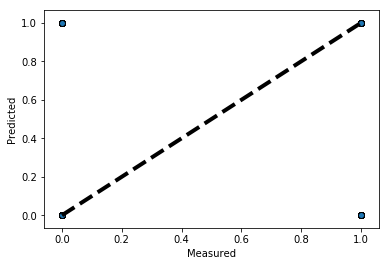

In [19]:
sm = SMOTE(random_state=12, ratio=1.0) # ratio is set to 1.0 for balanced dataset
x_res, y_res = sm.fit_sample(X_train, Y_train)

x_train_res, x_val_res, y_train_res, y_val_res = train_test_split(x_res, y_res, test_size = 0.3, random_state = 12)

tree_smote = DecisionTreeClassifier().fit(x_train_res, y_train_res)
bag_smote = BaggingClassifier(tree_smote, n_estimators=100, max_samples=0.8, random_state=1)
bag_smote.fit(x_train_res, y_train_res)
bag_smote_score = score_model(tree_smote, x_val_res, y_val_res)
print("SMOTE Accuracy with Bagging: ", bag_smote_score[0])
print("AUC Score: ", roc_auc_score(y_val_res, bag_smote_score[1]))
plot_model(y_val_res, bag_smote_score[1])

##### Interpretation
Woah, we see that the accuracy is really high here too! However, this time we are balancing the dataset by using SMOTE. With the combination of SMOTE and bagging, we can see that this data is now evenly distributed and its accuracy is less due from overfitting. 

### Classification Using Boosting
Boosting is used to reduce mostly bias, but also variance. This is done by generating many weak classifiers and at the end, create a strong classifier. This allows for data weights to be readjusted every time to reduce bias. 

#### Unbalanced Data

Since we already have unbalanced data prepared from before, all we have to do is put it into our model.

We will be using the Gradient Boosting Algorithm to minimize a loss function and maximize accuracy. 

Boosting Accuracy with Unbalanced and Oversampled Data:  0.9395
AUC Score:  0.5053721648148892


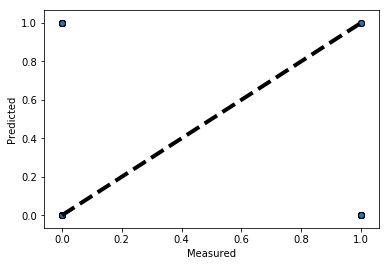

In [21]:
boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
boost.fit(X_train, Y_train)
boost_score = score_model(boost, x_test, y_test)
print("Boosting Accuracy with Unbalanced Data: ", boost_score[0])
print("AUC Score: ", roc_auc_score(y_test, boost_score[1]))
plot_model(y_test, boost_score[1])

##### Interpretation
Looking at this, we get a slightly better accuracy with unbalanced data using boosting instead of bagging. This is probably because boosting trains each weak classifier with all the data, but after each weak classifier is trained, it fixes the weights of the missclassified instances, slightly increasing accuracy. 

#### Oversampled Data
We have already prepared our oversampled dataset. Let's fit it in our model. 

Boosting Accuracy with Oversampled Data (Balanced):  0.6399521531100478
AUC Score:  0.6399521531100478


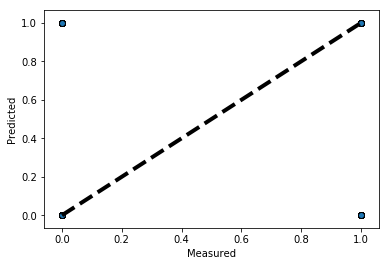

In [32]:
boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
boost_oversample = boost.fit(X_train_oversampled, Y_train_oversampled)
boost_oversample.fit(X_train_oversampled, Y_train_oversampled)
boost_oversample_score = score_model(boost_oversample, x_test_oversampled, y_test_oversampled)
print("Boosting Accuracy with Oversampled Data (Balanced): ", boost_oversample_score[0])
print("AUC Score: ", roc_auc_score(y_test_oversampled, boost_oversample_score[1]))
plot_model(y_test_oversampled, boost_oversample_score[1])


##### Interpretation
In this model, we can see a higher accuracy and AUC than the bagging with oversampling because we are simply using a better version of bagging (boosting based on gradient descent). 

#### Undersampled Data
Since we have a lot more people that didn't buy Caravan insurance, we need to undersample the data to get a higher training set. We will use the same modified dataset that was used in the "Undersampled Data" section for bagging. 

Boosting Accuracy with Undersampled Data (Balanced):  0.6079545454545454
AUC Score:  0.6137935534386011


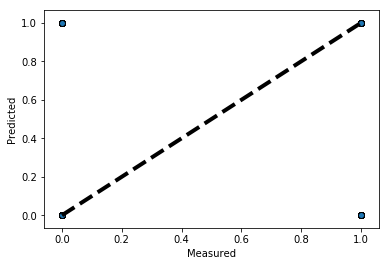

In [22]:
boost_undersample = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1)
boost_undersample.fit(X_undersample_train, Y_undersample_train)
boost_undersample_score = score_model(boost_undersample, x_undersample_test, y_undersample_test)
print("Boosting Accuracy with Undersampled Data (Balanced): ", boost_undersample_score[0])
print("AUC Score: ", roc_auc_score(y_undersample_test, boost_undersample_score[1]))
plot_model(y_undersample_test, boost_undersample_score[1])

##### Interpretation
Here, we see that the accuracy has increased a little from bagging with undersampled data. This is probably due to the fact that we used a Gradient-Boosting classifier, where it found optimality in accuracy and results.

#### SMOTE
Let's change up the dataset to use SMOTE!

Boosting Accuracy with SMOTE:  0.9473363774733637
AUC Score:  0.9477797348660424


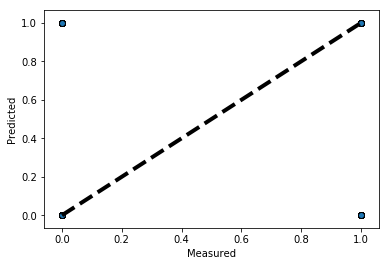

In [23]:
boost.fit(x_train_res, y_train_res)
boost_smote_score = score_model(boost, x_val_res, y_val_res)
print("Boosting Accuracy with SMOTE: ", boost_smote_score[0])
print("AUC Score: ", roc_auc_score(y_val_res, boost_smote_score[1]))
plot_model(y_val_res, boost_smote_score[1])

##### Interpretation
We see that this accuracy is even higher than the original accuracy without SMOTE and unbalanced data! This probably is because it generated a lot more data points than when I balanced the data (with less data points) by oversampling. More data = more accuracy (usually)

### Classification Using Random Forest
Essentially, random forest builds an ensemble of decision trees (most of the time trained with the bagging algorithm). It merges these decision trees together to get a more stable and accurate prediction. 

#### Unbalanced Data
Since we already have unbalanced data prepared from before, all we have to do is put it into our model. 

Random Forest Classification Accuracy with Unbalanced Data:  0.9315
AUC Score:  0.5286701602491076


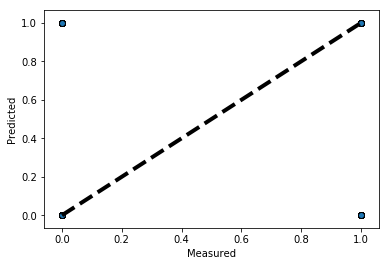

In [21]:
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X_train, Y_train)
rf_score = score_model(rf, x_test, y_test)
print("Random Forest Classification Accuracy with Unbalanced Data: ", rf_score[0])
print("AUC Score: ", roc_auc_score(y_test, rf_score[1]))
plot_model(y_test, rf_score[1])

##### Interpretation
Hm, we see that the accuracy is right in between bagging and boosting. Why is this? This is probably due to the fact that bagging did remove a lot of variance, but accuracy isn't completely improved. Boosting probably has a higher accuracy due to the fact that it is using a gradient descent algorithm to find the optimal solution. This is right in the middle, where there are multiple decision tree classifiers (instead of one) that work together in bringing an optimal result, which it did. 

#### Oversampled Data
Since we already have our data prepared, nothing has to be done. Let's fit our model. 

Random Forest Accuracy with Oversampled Data (Balanced):  0.5455874534821903
AUC Score:  0.5455874534821903


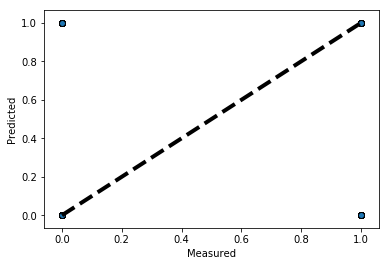

In [22]:
rf_oversample = RandomForestClassifier(n_estimators=100)
rf_oversample.fit(X_train_oversampled, Y_train_oversampled)
oversample_rf_score = score_model(rf_oversample, x_test_oversampled, y_test_oversampled)
print("Random Forest Accuracy with Oversampled Data (Balanced): ", oversample_rf_score[0])
print("AUC Score: ", roc_auc_score(y_test_oversampled, oversample_rf_score[1]))
plot_model(y_test_oversampled, oversample_rf_score[1])

##### Interpretation
Our accuracy and AUC did decrease here again. This is probably because the trees aren't always closer to the optimal solutions. Since boosting was using gradient descent, it's more optimal there. 

#### Undersampled Data
Since we have a lot more people that didn't buy Caravan insurance, we need to undersample the negative classes (0).

Random Forest Accuracy with Undersampled Data (Balanced):  0.6761363636363636
AUC Score:  0.673300274044108


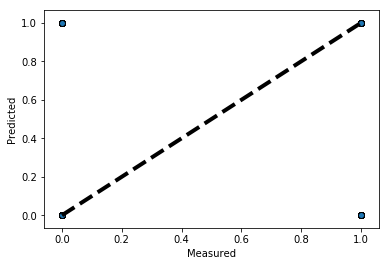

In [26]:
rf_undersample = RandomForestClassifier(n_estimators = 100)
rf_undersample.fit(X_undersample_train, Y_undersample_train)
undersample_rf_score = score_model(rf_undersample, x_undersample_test, y_undersample_test)
print("Random Forest Accuracy with Undersampled Data (Balanced): ", undersample_rf_score[0])
print("AUC Score: ", roc_auc_score(y_undersample_test, undersample_rf_score[1]))
plot_model(y_undersample_test, undersample_rf_score[1])

##### Interpretation


We see that this accuracy fluctuates close to the results from all of the samples. This is probably due to the fact that the accuracy isn't targetting exactness in a random forest. It is very good in removing biases (since it IS random). However, it isn't as accurate as Boosting.

#### SMOTE
Let's try this with SMOTE.

Random Forest Accuracy with SMOTE:  0.9552511415525115
AUC Score:  0.9554806711782701


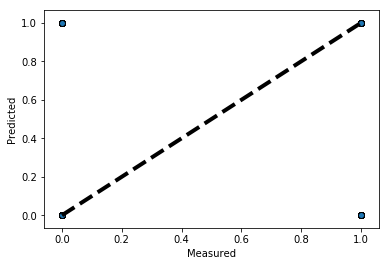

In [28]:
rf.fit(x_train_res, y_train_res)
rf_smote_score = score_model(rf, x_val_res, y_val_res)
print("Random Forest Accuracy with SMOTE: ", rf_smote_score[0])
print("AUC Score: ", roc_auc_score(y_val_res, rf_smote_score[1]))
plot_model(y_val_res, rf_smote_score[1])

This yielded the best accuracy out of all of the models. This is due to the ability of random forest to get a truly random set of datapoints to remove any biases and variance. It helps with bringing a bunch of random decision trees that have no biases in minority class (i.e. most people didn't buy insurance) and get a more accurate and fair model. 

## Conclusions
### Summary
Using a variety of decision tree-based models, I was able to explore the output of different ensemble-based helper classifiers to furthe improve accuracy and reduce bias/variance in the data. 
### Results
#### <center>Summary of Model Evaluation Results </center>

|    	| Model                                             	| AUC     	|
|----	|---------------------------------------------------	|---------	|
| 1  	| Bagging with Unbalanced Data                      	| 0.52800 	|
| 2  	| Bagging with Oversampled and Balanced Data        	| 0.54572 	|
| 3  	| Bagging with Undersampled and Balanced Data       	| 0.67045 	|
| 4  	| Bagging with SMOTE                                	| 0.91775 	|
| 5  	| Boosting with Unbalanced Data                     	| 0.50537 	|
| 6  	| Boosting with Oversampled and Balanced Data       	| 0.63995 	|
| 7  	| Boosting with Undersampled and Balanced Data      	| 0.61379 	|
| 8  	| Boosting with SMOTE                               	| 0.94777 	|
| 9  	| Random Forest with Unbalanced Data                	| 0.52867 	|
| 10 	| Random Forest with Oversampled and Balanced Data  	| 0.54558 	|
| 11 	| Random Forest with Undersampled and Balanced Data 	| 0.67330 	|
| 12 	| Random Forest with SMOTE                          	| 0.95548 	|


### Skills
* Ability to use diffeerent classification algorithms using cleaned datasets
* Using ensemble classifiers that reduce bias (boosting), variance (bagging), and increase effect of minority classes (SMOTE)
* Using numpy and pandas for pre-processing
* Properly splitting the data between train and test datsets